In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from MainAnalysis import * # includes visualizations, preprocessing, and tf-idf
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\20202650\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\20202650\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

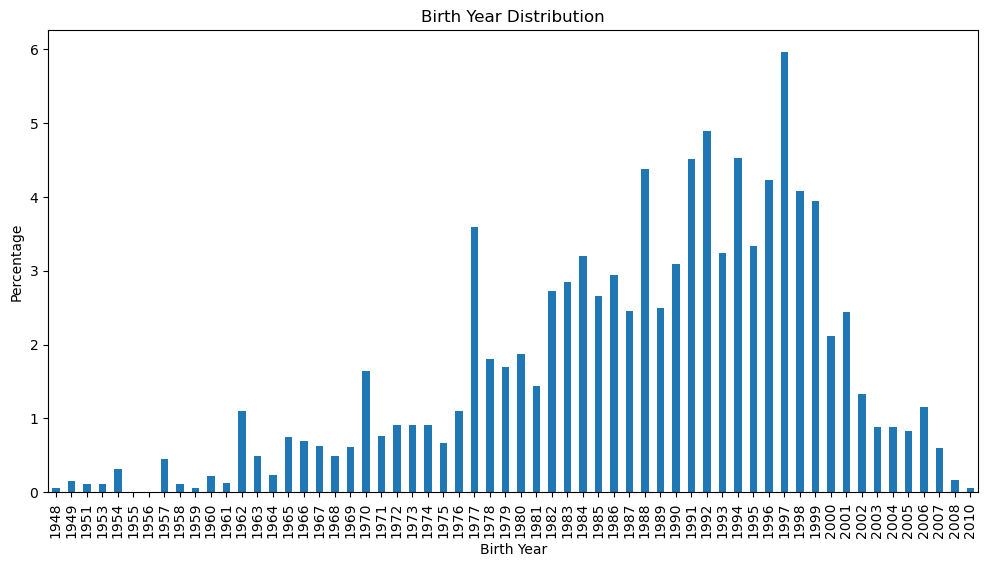

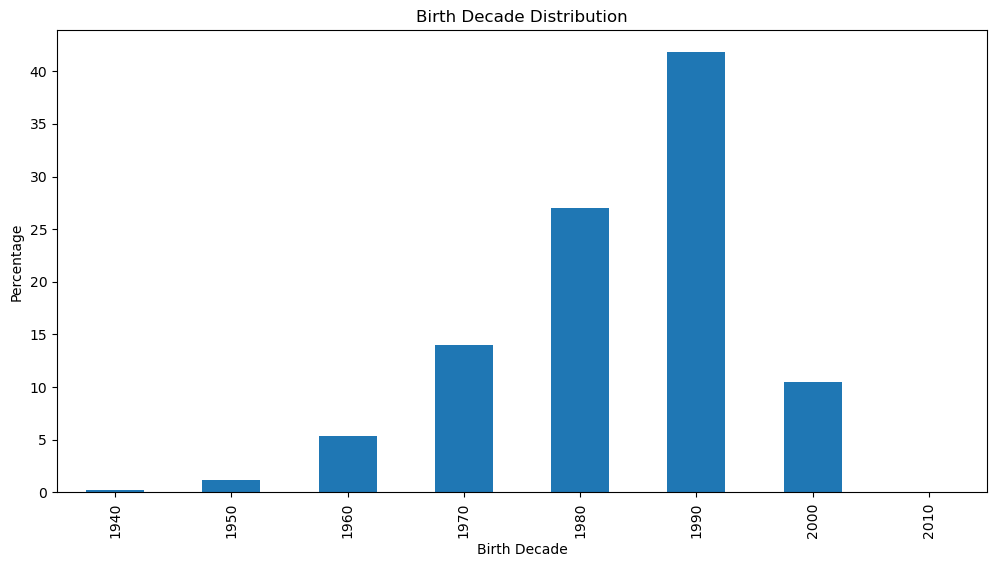

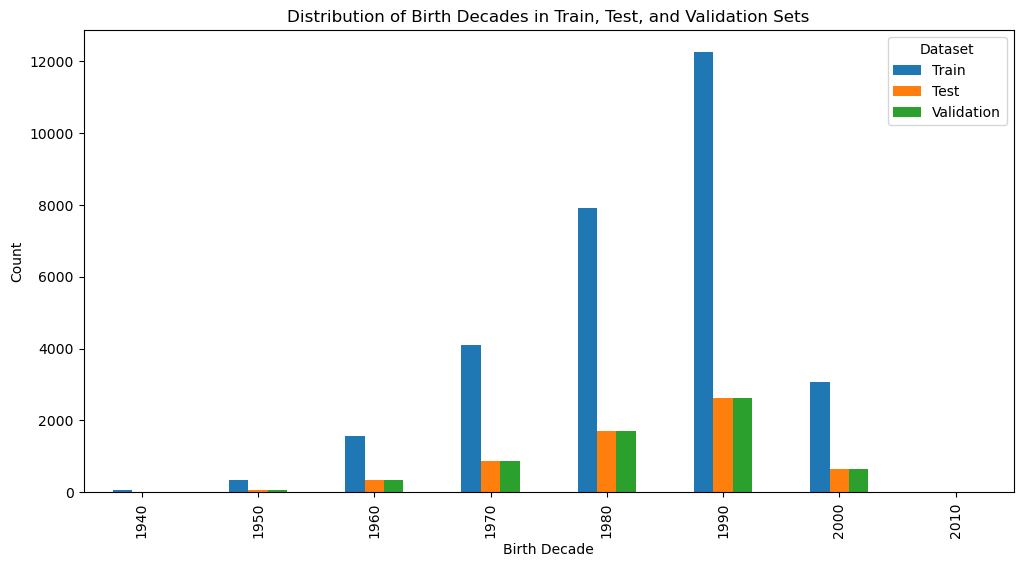

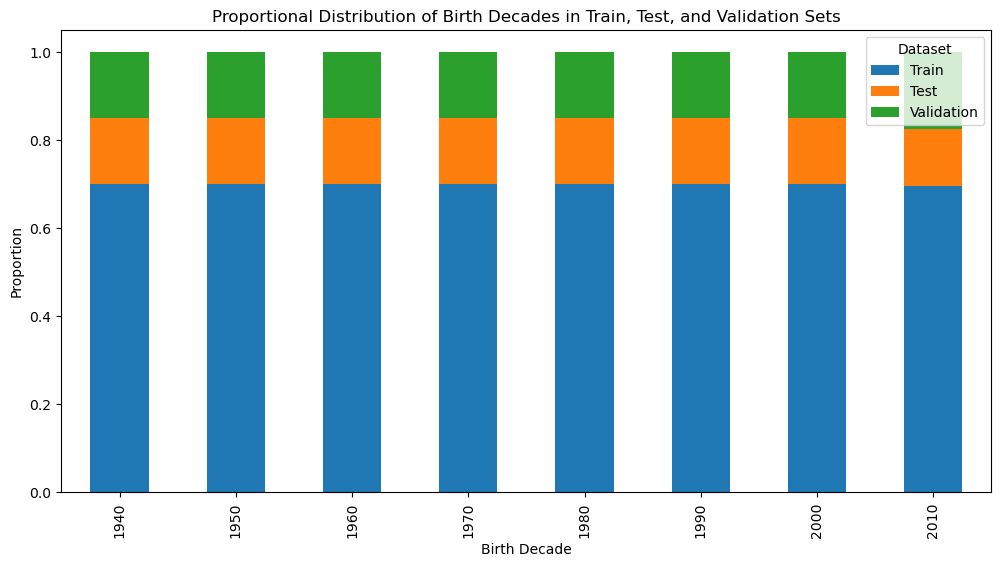

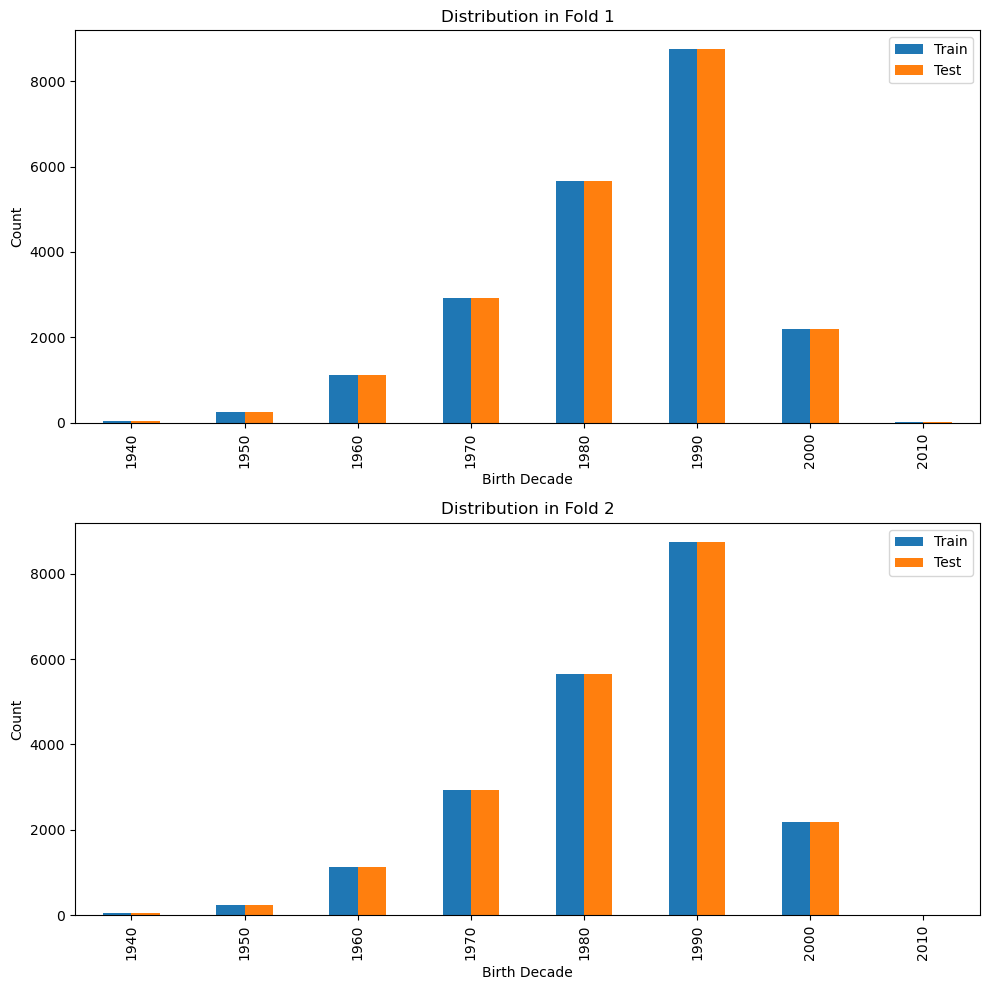

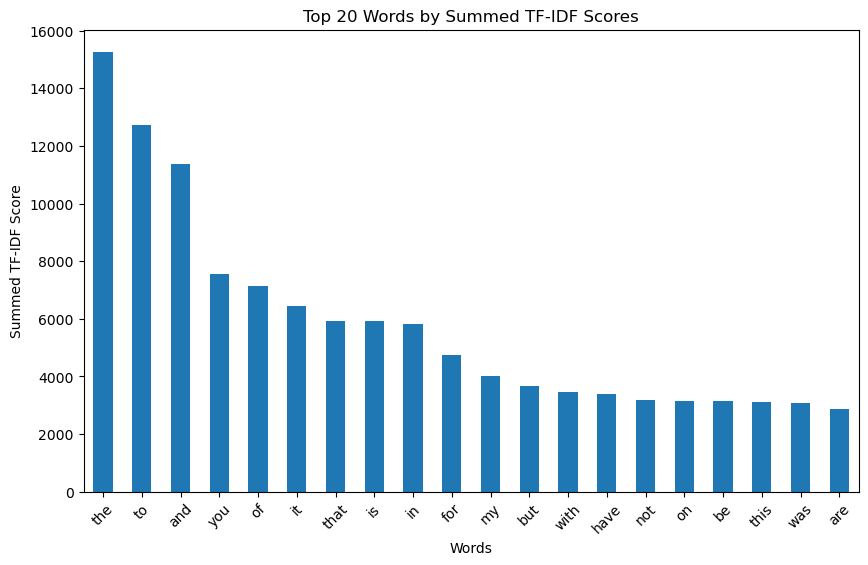

In [2]:
data = pd.read_csv("../Data/birth_year.csv")
analysis = MainAnalysis(data, max_features=1000)
train_data, test_data = analysis.run()

In [3]:
class ModelCollection():
    def __init__(self, models:list, feature_names) -> None:
        self.models = models
        self.model_names = [model.__class__.__name__ for model in models]
        self.feature_names = feature_names # should be vectorizer.get_feature_names_out()

    def fit(self, X_train, y_train):
        print('Trained model:\t', end='')
        for i, model in enumerate(self.models):
            model.fit(X_train, y_train)
            self.models[i] = model
            print(i, end=' ')

    def predict(self, X_test):
        self.y_preds = []
        print('Predicted model:\t', end='')
        for i, model in enumerate(self.models):
            y_pred = model.predict(X_test)
            self.y_preds.append(y_pred)
            print(i, end=' ')
        return self.y_preds
    
    def EvaluationMetrics(self, y_true, y_preds):
        scores = {'r2':[], 'mse':[], 'rmse': [], 'mae': []}
        for y_pred in y_preds:
            scores['r2'].append(r2_score(y_true, y_pred))
            scores['mse'].append(mean_squared_error(y_true, y_pred))
            scores['rmse'].append(mean_squared_error(y_true, y_pred, squared=False))
            scores['mae'].append(mean_absolute_error(y_true, y_pred))

        scores_df = pd.DataFrame(scores, index=self.model_names)
        display(scores_df)
        scores_df.to_csv('EvaluationMetrics.csv')
        return scores_df

    def get_n_most_influential(self, n:int):
        
        feature_importances_dict = {'coefficient':[], 'words':[], 'model':[]}
        for model, name in zip(self.models, self.names):
            match name:
                case 'LinearRegressor':
                    feature_importances = model.coef_
                case 'SVR':
                    feature_importances = np.array(model.coef_.todense()).flatten()
                case 'DecisionTreeRegressor' | 'RandomForestRegressor':
                    feature_importances = self.model.feature_importances_
            
            feature_importances_dict['coefficient'].append(feature_importances)
            feature_importances_dict['words'].append(self.feature_names)
            feature_importances_dict['model'].append([name] * len(feature_importances))

        feature_importances = pd.DataFrame(feature_importances_dict)
        feature_importances = feature_importances.sort_values(by='coefficient', ascending=False, ignore_index=True)
        feature_importances.to_csv('feature_importances_per_model.csv')

        return feature_importances.iloc[:n,:]
    
    def overlapping_features(self, n:int):
        feature_importances = self.get_n_most_influential(n, self.feature_names)
        n_overlapping = pd.DataFrame(columns = self.model_names, index= self.model_names)
        overlapping = pd.DataFrame(columns = self.model_names, index= self.model_names)

        for model_1, name_1 in zip(self.models, self.model_names):
            for model_2, name_2 in zip(self.models, self.model_names):

                if name_1 == name_2:
                    continue
                feature_names_1 = feature_importances[feature_importances['model'] == name_1]['words']
                feature_names_2 = feature_importances[feature_importances['model'] == name_2]['words']

                overlapping_features_ = set(feature_names_1).intersection( set(feature_names_2) )
                n_overlapping_features = len(overlapping_features_)

                n_overlapping.loc[name_1, name_2] = n_overlapping.loc[name_2, name_1] = n_overlapping_features
                overlapping.loc[name_1, name_2] = overlapping.loc[name_2, name_1] = overlapping_features_
        
        n_overlapping.to_csv('n_overlapping.csv')
        overlapping.to_csv('overlapping.csv')
        return n_overlapping, overlapping

    def visualize_feature_importances(self, n:int):
        for model, name in zip(self.models, self.model_names):
            importances = self.get_n_most_influential(n) 
            importances_filtered = importances[importances['model'] == name]
            sns.barplot(data=importances_filtered, x='coefficient', y = 'words', orient='y')   
            plt.show()

In [4]:
models = ModelCollection([DecisionTreeRegressor(),
                          RandomForestRegressor(n_estimators=5, random_state=42),
                          SVR(kernel='linear', verbose=True),
                          LinearRegression()],
                          analysis.tfidf_transformer.tfidf_vectorizer.get_feature_names_out())

In [ ]:
class Analysis():
    def __init__(self, data, max_features:int=1000) -> None:
        self.data = MainAnalysis(data, max_features).run() # should then have preprocessed self.data split into train and test
        self.modelCollection = ModelCollection([DecisionTreeRegressor(),
                                                RandomForestRegressor(n_estimators=5, random_state=42),
                                                SVR(kernel='linear', verbose=True),
                                                LinearRegression()],
                                                analysis.tfidf_transformer.tfidf_vectorizer.get_feature_names_out()) 
        
    def run(self, n=100):
        # following two should then be implemented in MainAnalysis that extracts the respective datasets
        X_train, y_train = self.data.get_training_data()
        X_test, y_test = self.data.get_test_data()

        self.modelCollection.fit(X_train, y_train)
        y_preds = self.modelCollection.predict(X_test)

        self.modelCollection.EvaluationMetrics(y_test, y_preds)
        self.modelCollection.overlapping_features(n)
        self.modelCollection.visualize_feature_importances(n)
